In [10]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore", category=UserWarning)  # UserWarning 억제
warnings.filterwarnings("ignore", category=FutureWarning) # FutureWarning 억제

# 심볼 목록 정의
crypto_symbols = ["BTC-USD","BCH-USD", "SOL-USD", "XRP-USD", "AAVE-USD", "APT21794-USD","ARB11841-USD","AVAX-USD","COTI-USD", "CRV-USD", "EOS-USD","ETC-USD","ETH-USD","FET-USD",
                  "FTM-USD","GALA-USD", "LDO-USD", "LINK-USD","LTC-USD","NEAR-USD", "ONDO-USD","SEI-USD", "UNI7083-USD", "WLD-USD"]

# 현재 날짜와 시간 가져오기
now = datetime.now()
current_hour = now.replace(minute=0, second=0, microsecond=0)  # 현재 시각의 시 만큼 자르고 더 작은 단위는 0으로 설정

# 데이터 가져오기
crypto_data = yf.download(crypto_symbols, start=current_hour - timedelta(days=30), end=current_hour, interval="1h").fillna(method='ffill')

# Close 가격만 선택
close_prices = crypto_data['Close']

# 오늘 포함된 데이터 확인
print(close_prices.tail(2))

[*********************100%***********************]  24 of 24 completed


Ticker                       AAVE-USD  APT21794-USD  ARB11841-USD   AVAX-USD  \
Datetime                                                                       
2024-12-12 12:00:00+00:00  383.286224     13.785862      1.068694  50.318882   
2024-12-12 13:00:00+00:00  383.229858     13.785257      1.073879  50.316647   

Ticker                        BCH-USD        BTC-USD  COTI-USD   CRV-USD  \
Datetime                                                                   
2024-12-12 12:00:00+00:00  551.965210  100869.078125  0.177226  1.125747   
2024-12-12 13:00:00+00:00  551.744873  100844.726562  0.177211  1.125091   

Ticker                      EOS-USD    ETC-USD  ...   LDO-USD   LINK-USD  \
Datetime                                        ...                        
2024-12-12 12:00:00+00:00  1.124923  34.885571  ...  2.112594  27.767775   
2024-12-12 13:00:00+00:00  1.125009  34.896870  ...  2.127239  27.771212   

Ticker                        LTC-USD  NEAR-USD  ONDO-USD   SEI-USD  

In [11]:
# 일반 수익률 계산
returns = crypto_data['Close'].pct_change(fill_method=None).dropna()  # 결측치를 채우지 않음

# 변동성 계산 함수
def calculate_volatility(data, window):
    return data.rolling(window=window).std()

# 각 주기에 대한 변동성 계산
volatility_1h = returns.std() * np.sqrt(1)  # 1시간 변동성
volatility_12h = returns.resample('12h').std().mean() * np.sqrt(12)  # 4시간 변동성
volatility_1D = returns.resample('D').std().mean() * np.sqrt(24)  # 일간 변동성
volatility_3D = returns.resample('3D').std().mean() * np.sqrt(24 * 3)  # 주간 변동성

# 포트폴리오 기대 수익률 (평균으로 설정)
portfolio_return = returns.mean()

# 샤프 지수 계산 (일간 기반)
sharpe_1D = (portfolio_return * 24 - 0) / volatility_1D  # 일간 샤프 비율


# 결과를 데이터프레임으로 정리
volatility_df = pd.DataFrame({
    '1H': (volatility_1h * 100).round(1),
    '12H': (volatility_12h * 100).round(1),
    '1D': (volatility_1D * 100).round(1),
    '3D': (volatility_3D * 100).round(1),
    'Sharpe': sharpe_1D.round(2),
})

# Daily 기준으로 내림차순 정렬
volatility_df_sorted = volatility_df.sort_values(by='1D')

# 결과 출력
print(volatility_df_sorted)

               1H  12H   1D    3D  Sharpe
Ticker                                   
BTC-USD       0.6  1.9  2.8   4.9    0.20
ETH-USD       0.8  2.5  3.5   6.4    0.20
SOL-USD       0.9  3.0  4.3   7.6    0.10
BCH-USD       1.3  4.0  5.8  10.2    0.18
AVAX-USD      1.4  4.4  6.3  11.1    0.25
APT21794-USD  1.4  4.4  6.4  11.4    0.09
ETC-USD       1.4  4.7  6.6  11.8    0.26
NEAR-USD      1.4  4.7  6.7  11.8    0.20
LTC-USD       1.5  4.7  6.7  12.1    0.28
AAVE-USD      1.5  4.9  6.9  12.9    0.42
ARB11841-USD  1.5  4.8  6.9  12.5    0.30
LINK-USD      1.5  4.8  7.0  13.3    0.37
UNI7083-USD   1.5  5.0  7.1  12.7    0.39
FET-USD       1.5  5.1  7.3  12.9    0.17
ONDO-USD      1.6  5.1  7.5  13.2    0.37
SEI-USD       1.6  5.2  7.5  13.1    0.19
LDO-USD       1.6  5.3  7.6  13.8    0.31
EOS-USD       1.7  5.5  7.9  13.8    0.35
FTM-USD       1.7  5.5  8.0  13.8    0.28
COTI-USD      1.8  5.7  8.2  14.5    0.26
WLD-USD       1.8  5.7  8.3  14.7    0.16
GALA-USD      1.8  6.0  8.5  15.0 

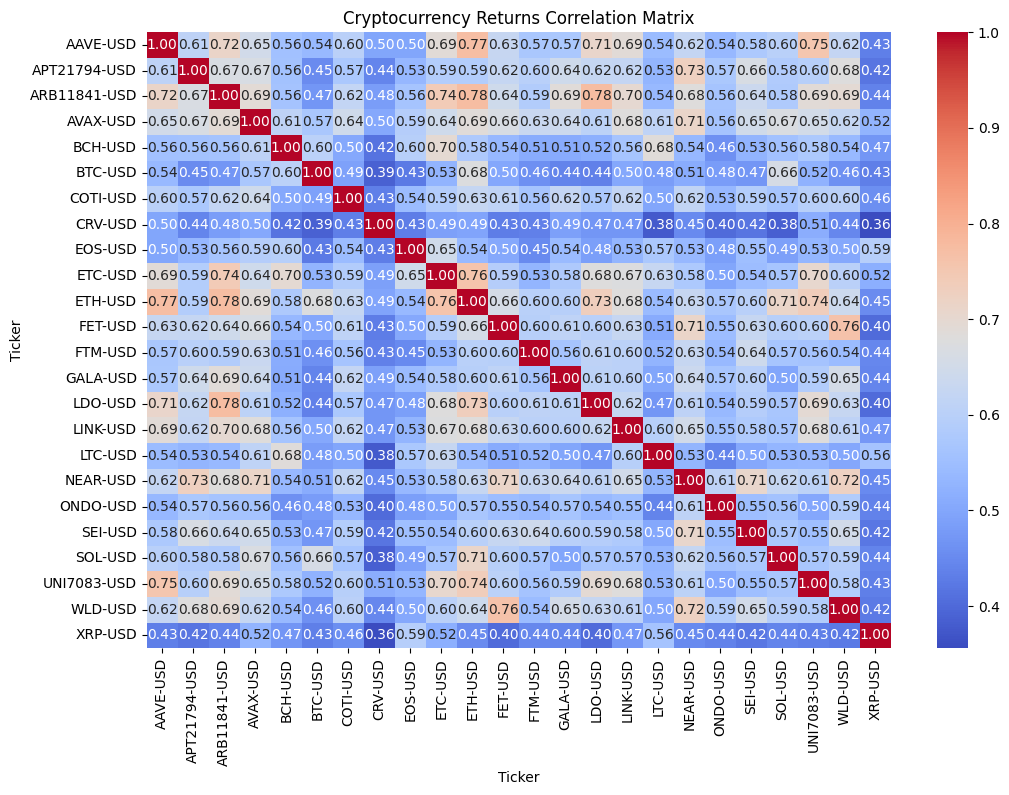

In [14]:
# 상관관계 계산
correlation_matrix = returns.corr()

# 상관관계 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Cryptocurrency Returns Correlation Matrix')
plt.show()

In [15]:
### 최근 종가 가져오기
recent_close_prices = crypto_data['Close'].iloc[-1]  # 최신 종가

# recent_close_prices['BONK-USD'] = recent_close_prices['BONK-USD'] * 1000

# 변동성을 기준으로 가격 계산
Down_prices_1D = recent_close_prices * (1 - (volatility_1D))  # 12시간 변동성 적용
Down_prices_3D = recent_close_prices * (1 - (volatility_3D))  # 일간 변동성 적용
Up_prices_1D = recent_close_prices * (1 + (volatility_1D))  # 일간 변동성 적용
Up_prices_3D = recent_close_prices * (1 + (volatility_3D))  # 일간 변동성 적용


# 결과를 새로운 데이터프레임으로 정리
adjusted_prices_df = pd.DataFrame({
    'Down Price (1D)': Down_prices_1D.round(4),
    'Down Price (3D)': Down_prices_3D.round(4),
    'Up Price (1D)': Up_prices_1D.round(4),
    'Up Price (3D)': Up_prices_3D.round(4)
})
# 결과 출력
print("\nAdjusted Prices DataFrame:")
print(adjusted_prices_df)


Adjusted Prices DataFrame:
              Down Price (1D)  Down Price (3D)  Up Price (1D)  Up Price (3D)
Ticker                                                                      
AAVE-USD             356.9154         333.8598       409.5443       432.6000
APT21794-USD          12.9057          12.2129        14.6648        15.3576
ARB11841-USD           0.9995           0.9399         1.1483         1.2079
AVAX-USD              47.1345          44.7185        53.4987        55.9148
BCH-USD              519.5629         495.4601       583.9269       608.0297
BTC-USD            98060.2833       95903.7585    103629.1698    105785.6946
COTI-USD               0.1626           0.1515         0.1918         0.2029
CRV-USD                1.0139           0.9240         1.2363         1.3262
EOS-USD                1.0360           0.9694         1.2140         1.2807
ETC-USD               32.5843          30.7670        37.2095        39.0268
ETH-USD             3817.4425        3704.3433  

In [5]:
returns = crypto_data['Close'].pct_change().dropna()

# 사용자로부터 각 암호화폐의 수량 입력 받기
quantities = ({
  "BTC-USD": 000,
  "BCH-USD": 3,
  "SOL-USD": 000,
  "AAVE-USD": 000,
  "APT21794-USD": 00,
  "ARB11841-USD": 800,
  "AVAX-USD": 30,
  "COTI-USD": 6000,
  "CRV-USD": 2500,
  "EOS-USD": 00,
  "ETC-USD": 30,
  "ETH-USD": 0.5,
  "FET-USD": 500,
  "FTM-USD": 750,
  "GALA-USD": 00000,
  "LDO-USD": 800,
  "LINK-USD": 000,
  "LTC-USD": 10,
  "NEAR-USD": 150,
  "ONDO-USD": 000,
  "SEI-USD": 0000,
  "UNI7083-USD":100,
  "XRP-USD": 0000,
  "WLD-USD": 500,


})

# 현재 가격 가져오기
latest_prices = crypto_data['Close'].iloc[-1]

# 포트폴리오의 각 암호화폐의 현재 가치를 계산
portfolio_value = sum(latest_prices[symbol] * quantities[symbol] for symbol in quantities.keys())

# 포트폴리오 비중 계산
weights = {symbol: (latest_prices[symbol] * quantities[symbol]) / portfolio_value for symbol in quantities.keys()}

# Pandas Series로 변환
weights = pd.Series(weights)

crypto_symbols = list(weights.index)

# 공분산 행렬 계산
cov_matrix = returns.cov()

# 포트폴리오 변동성 계산 (일간으로 변환)
portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
portfolio_volatility_hourly = np.sqrt(portfolio_variance)
portfolio_volatility_daily = portfolio_volatility_hourly * np.sqrt(24)  # 하루 동안의 변동성

# 일간 포트폴리오 기대 수익률 계산
portfolio_mean_hourly = np.dot(weights.T, returns.mean())
portfolio_mean_daily = (1 + portfolio_mean_hourly) ** 24 - 1  # 복리 수익률 변환

# 95% 신뢰수준에서의 VaR 계산
z_score = norm.ppf(0.05)
var_95_daily = -z_score * portfolio_volatility_daily * portfolio_value  # 포트폴리오 가치

# 결과 출력
print(f"Daily Portfolio Volatility: {portfolio_volatility_daily:.2%}")
print(f"Daily Portfolio Mean: {portfolio_mean_daily:.2%}")
print(f"95% VaR (daily, value): ${var_95_daily:,.2f} ({var_95_daily/portfolio_value:.2%})")
print(f"Portfolio_Value: {portfolio_value:,.2f}")

Daily Portfolio Volatility: 5.93%
Daily Portfolio Mean: 2.53%
95% VaR (daily, value): $1,982.42 (9.76%)
Portfolio_Value: 20,321.09


In [6]:
# 각 코인별 VaR 계산 및 출력
individual_vars = []  # 각 코인별 VaR를 저장할 리스트

for symbol in crypto_symbols:
    weight = weights[symbol]
    if weight > 0:  # 롱 포지션이 있는 경우에만 VaR 계산
        individual_mean = returns[symbol].mean() * 24  # 일간 기대 수익률
        individual_volatility = returns[symbol].std() * np.sqrt(24)  # 일간 변동성

        individual_var_dollar = weight * (-z_score * individual_volatility * portfolio_value)  # 금액 손실
        individual_var_percent = (individual_var_dollar / portfolio_value) * 100  # 퍼센트 손실

        print(f"{symbol} : ${individual_var_dollar:.2f} ({individual_var_percent:.2f}%)")
        individual_vars.append(individual_var_dollar)  # VaR를 리스트에 추가

# 95% VaR의 총합 계산 및 출력
total_var_95 = sum(individual_vars)
print(f"\nTotal 95% VaR (daily, value): ${total_var_95:.2f}")

BCH-USD : $172.84 (0.85%)
ARB11841-USD : $103.42 (0.51%)
AVAX-USD : $164.30 (0.81%)
COTI-USD : $153.88 (0.76%)
CRV-USD : $487.76 (2.40%)
ETC-USD : $118.94 (0.59%)
ETH-USD : $121.25 (0.60%)
FET-USD : $116.11 (0.57%)
FTM-USD : $134.33 (0.66%)
LDO-USD : $225.38 (1.11%)
LTC-USD : $149.20 (0.73%)
NEAR-USD : $122.63 (0.60%)
UNI7083-USD : $228.02 (1.12%)
WLD-USD : $227.52 (1.12%)

Total 95% VaR (daily, value): $2525.58


In [13]:
# 공분산 행렬 계산
cov_matrix = returns.cov()
mean_returns = returns.mean()

# 코인 그룹 나누기 (예시) - 실제 코인 목록에 맞춰 수정해야 합니다.
first_group = ["BTC-USD","BCH-USD", "SOL-USD","XRP-USD", "ETH-USD"]
second_group = ["AAVE-USD", "APT21794-USD","ARB11841-USD", "AVAX-USD","COTI-USD", "CRV-USD", "EOS-USD", "ETC-USD", "FET-USD",
               "FTM-USD","GALA-USD","LDO-USD","LTC-USD","LINK-USD","NEAR-USD", "ONDO-USD","SEI-USD", "UNI7083-USD", "WLD-USD"]

# crypto_symbols 리스트 중복 제거
crypto_symbols = list(set(first_group + second_group))

crypto_symbols = first_group + second_group

# first_group와 second_group에 해당하는 인덱스 얻기
first_indices = [crypto_symbols.index(symbol) for symbol in first_group]
second_indices = [crypto_symbols.index(symbol) for symbol in second_group]


# 최소 변동성과 최대 샤프 비율 최적화 함수 (수정)
def optimize_portfolio(weights):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = portfolio_return / portfolio_volatility
    return -sharpe_ratio # 샤프 비율 최대화를 위해 - 부호를 제거

# 초기 비중 설정
num_assets = len(crypto_symbols)
initial_weights = np.array([1.0 / num_assets] * num_assets)

# 제약 조건 (수정)
constraints = (
    {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # 전체 비중 1
    {'type': 'eq', 'fun': lambda weights: np.sum(weights[first_indices]) - 0.8},  # FIRST 그룹 비중 80%
    {'type': 'eq', 'fun': lambda weights: np.sum(weights[second_indices]) - 0.2}  # SECOND 그룹 비중 20%
)
bounds = tuple((0, 1) for asset in range(num_assets))

# 최적화 실행 및 결과 출력 (기존 코드 동일)
optimized_results = minimize(optimize_portfolio, initial_weights, method='trust-constr', bounds=bounds, constraints=constraints, options={'maxiter':1000}) #maxiter 추가


# 최적화된 비중
optimal_weights = optimized_results.x
optimal_weights=pd.Series(optimized_results.x, index=crypto_symbols) # index 추가
optimal_weights = optimal_weights.sort_values(ascending=False)

optimal_return = np.dot(optimal_weights, mean_returns) * 24
optimal_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights))) * np.sqrt(24)
optimal_sharpe = optimal_return / optimal_volatility

print("Optimal Portfolio:")
for i, weight in enumerate(optimal_weights.round(3)):
    print(f"{optimal_weights.index[i]}: {weight:.1%}") #index 사용

print(f"\nExpected Daily Return: {optimal_return:.2%}")
print(f"Daily Volatility: {optimal_volatility:.2%}")
print(f"Sharpe Ratio: {optimal_sharpe:.2f}")

Optimal Portfolio:
BTC-USD: 24.9%
SOL-USD: 17.6%
XRP-USD: 14.9%
ETH-USD: 13.4%
BCH-USD: 9.3%
ARB11841-USD: 2.0%
WLD-USD: 1.9%
LINK-USD: 1.2%
AVAX-USD: 1.2%
SEI-USD: 1.2%
GALA-USD: 1.1%
FET-USD: 1.1%
FTM-USD: 1.0%
LDO-USD: 1.0%
ETC-USD: 1.0%
APT21794-USD: 0.9%
AAVE-USD: 0.9%
COTI-USD: 0.9%
CRV-USD: 0.8%
LTC-USD: 0.8%
NEAR-USD: 0.8%
ONDO-USD: 0.8%
EOS-USD: 0.7%
UNI7083-USD: 0.7%

Expected Daily Return: 1.85%
Daily Volatility: 5.74%
Sharpe Ratio: 0.32
